# Prepare

## Clone the repo

In [1]:
%cd /content
!rm -rf arabic-poetry-speech-classification
!git clone https://github.com/MagedSaeed/arabic-poetry-speech-classification.git
%cd arabic-poetry-speech-classification

/content
Cloning into 'arabic-poetry-speech-classification'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 49 (delta 21), reused 30 (delta 11), pack-reused 0
Unpacking objects: 100% (49/49), done.
/content/arabic-poetry-speech-classification


## Install Requirements

In [2]:
%%capture
!pip install -r requirements.txt

In [3]:
%%capture
!pip install torchaudio
!pip install transformers
!pip install datasets
!pip install lang_trans
!pip install arabic_reshaper
!pip install python-bidi
!pip install pydub
!pip install tnkeeh
!pip install soundfile
!pip install jiwer==2.2.0
!pip install PyArabic

## Imports

In [6]:
import os
import torch
import librosa
import torchaudio
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import tensorflow as tf
from pyarabic import araby
from datasets import Dataset
from pydub import AudioSegment
from audio_utils import get_audio
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor,Wav2Vec2PreTrainedModel,Wav2Vec2FeatureExtractor,Wav2Vec2Model

## Helper Classes and methods

In [4]:
class CustomWav2Vec2Processor:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
        self.current_processor = self.feature_extractor

    def save_pretrained(self, save_directory):
        self.feature_extractor.save_pretrained(save_directory)

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, **kwargs):
        feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
            pretrained_model_name_or_path, **kwargs
        )
        return cls(feature_extractor=feature_extractor)

    def __call__(self, *args, **kwargs):
        return self.current_processor(*args, **kwargs)

    def pad(self, *args, **kwargs):
        return self.current_processor.pad(*args, **kwargs)

In [7]:
class Wav2Vec2ClassificationModel(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.wav2vec2 = Wav2Vec2Model(config)

        self.inner_dim = 128
        self.feature_size = 999

        self.tanh = nn.Tanh()
        self.linear1 = nn.Linear(1024, self.inner_dim)
        self.linear2 = nn.Linear(self.inner_dim * self.feature_size, 16)
        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def forward(
        self,
        input_values,
        attention_mask=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        labels=None,
    ):
        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )

        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        x = self.linear1(outputs[0])
        x = self.tanh(x)
        x = self.linear2(x.view(-1, self.inner_dim * self.feature_size))
        return {"logits": x}

In [8]:
char2idx = {
    " ": 1,
    "#": 2,
    "ء": 3,
    "آ": 4,
    "أ": 5,
    "ؤ": 6,
    "إ": 7,
    "ئ": 8,
    "ا": 9,
    "ب": 10,
    "ة": 11,
    "ت": 12,
    "ث": 13,
    "ج": 14,
    "ح": 15,
    "خ": 16,
    "د": 17,
    "ذ": 18,
    "ر": 19,
    "ز": 20,
    "س": 21,
    "ش": 22,
    "ص": 23,
    "ض": 24,
    "ط": 25,
    "ظ": 26,
    "ع": 27,
    "غ": 28,
    "ف": 29,
    "ق": 30,
    "ك": 31,
    "ل": 32,
    "م": 33,
    "ن": 34,
    "ه": 35,
    "و": 36,
    "ى": 37,
    "ي": 38,
}
meters_mapping = {
    0: 4,
    1: 6,
    2: 8,
    3: 7,
    4: 13,
    5: 10,
    6: 9,
    7: 3,
    8: 0,
    9: 1,
    10: 5,
    11: 15,
    12: 14,
    13: 2,
}
meter_class_to_label = {v:k for k,v in {
    "البسيط": 0,
    "الخفيف": 1,
    "الرجز": 2,
    "الرمل": 3,
    "السريع": 4,
    "الطويل": 5,
    "الكامل": 6,
    "المتدارك": 7,
    "المتقارب": 8,
    "المجتث": 9,
    "المديد": 10,
    "المضارع": 11,
    "المقتضب": 12,
    "المنسرح": 13,
    "الهزج": 14,
    "الوافر": 15,
}.items()}

In [9]:
resamplers = {  # all three sampling rates exist in test split
    48000: torchaudio.transforms.Resample(48000, 16000),
    44100: torchaudio.transforms.Resample(44100, 16000),
    32000: torchaudio.transforms.Resample(32000, 16000),
}


def get_resampled_speech(file_path,srate=16_000):
  speech, sampling_rate = librosa.load(file_path, sr=srate)
    # original_speech, sampling_rate = torchaudio.load(file_path)
    # if sampling_rate in resamplers:
    #     speech = resamplers[sampling_rate](original_speech[0]).squeeze().numpy()
    # else:
    #     speech = resamplers[48000](original_speech[0]).squeeze().numpy()
  return speech

def put_hash_after_middle_word(sentence):
    middle_char = len(sentence) // 2
    closest_space_index = middle_char
    while True:
        try:
            if sentence[closest_space_index] == " ":
                break
            else:
                closest_space_index += 1
        except:
            closest_space_index = len(sentence) - 1
            break
    sentence = sentence[:closest_space_index] + " #" + sentence[closest_space_index:]
    return sentence

In [10]:
class Transcriber:
    def __init__(self, model_path, processor_path="bakrianoo/sinai-voice-ar-stt"):
        self.processor = Wav2Vec2Processor.from_pretrained(processor_path)
        self.model = Wav2Vec2ForCTC.from_pretrained(model_path).eval()
        self.model.to("cuda")

    def transcribe(self, file_path):
        speech = get_resampled_speech(file_path)
        inputs = self.processor(
            speech, sampling_rate=16000, return_tensors="pt", padding=True
        )
        with torch.no_grad():
            predicted = torch.argmax(self.model(inputs.input_values.to('cuda')).logits, dim=-1)
        predicted[predicted == -100] = self.processor.tokenizer.pad_token_id
        predicted_tokenized = self.processor.tokenizer.batch_decode(predicted)
        return predicted_tokenized

In [11]:
class SignalClassifier:
    def __init__(self, model_path):
        self.feature_extractor = Wav2Vec2FeatureExtractor(
            feature_size=1,
            sampling_rate=16_000,
            padding_value=0.0,
            do_normalize=True,
            return_attention_mask=True,
        )
        self.processor = CustomWav2Vec2Processor(feature_extractor=self.feature_extractor)
        self.model = Wav2Vec2ClassificationModel.from_pretrained(model_path).eval()
        self.model.to("cuda")

    def classify(self, file_path):
        speech = get_resampled_speech(file_path)
        features = self.processor(
            speech[:320000],
            max_length=320000,
            sampling_rate=16000,
            pad_to_multiple_of=320000,
            padding=True,
            return_tensors="pt",
        )
        print(features)
        # plt.plot(len(features.input_values), features.input_values)
        attention_mask = features.attention_mask.to("cuda")
        with torch.no_grad():
            logits = self.model(
                    features.input_values.to("cuda"), attention_mask=attention_mask
                )["logits"]
            print(logits)
            predicted = torch.argmax(
                logits,
                dim=-1,
            )
        meter_class = predicted.tolist()[0]
        return meter_class_to_label[meter_class]

In [12]:
class TextClassifier:
    def __init__(self, transcriber, model_path='/content/drive/MyDrive/KFUPM-Master/ICS606/Models/arabic_poetry_text_classification_model.h5'):
        self.model = tf.keras.models.load_model(model_path)
        self.transcriber = transcriber

    def classify(self, file_path):
        predicted_text = self.transcriber.transcribe(file_path)[0]
        predicted_text = araby.strip_tashkeel(predicted_text)
        predicted_text = put_hash_after_middle_word(predicted_text)
        sequence = [char2idx[char] for char in predicted_text if char2idx.get(char)]
        sequence = pad_sequences([sequence], maxlen=100, padding="post", value=0)
        predictions = self.model.predict(sequence)[0]
        label = meters_mapping[np.argmax(predictions, 0).astype("int")]
        return meter_class_to_label[label]

# Model Paths

In [117]:
transcribtion_original_model = "bakrianoo/sinai-voice-ar-stt"
transcribition_finetuned_model = '/content/drive/MyDrive/KFUPM-Master/ICS606/Models/SinaiFineTuned/checkpoint-1600'
signal_classification_original_model = '/content/drive/MyDrive/KFUPM-Master/ICS606/Models/ClassificationModelSinai/checkpoint-7000'
signal_classification_finetuned_model = '/content/drive/MyDrive/KFUPM-Master/ICS606/Models/ClassificationModelSinaiFineTuned/checkpoint-6500'
text_to_meter_label_classifier = '/content/drive/MyDrive/KFUPM-Master/ICS606/Models/arabic_poetry_text_classification_model.h5'
signal_classification_original_model_no_shuffled_dataset = '/content/drive/MyDrive/KFUPM-Master/ICS606/Models/NoShuffledDatasetOverfitting'

# Voice Input

In [ ]:
get_audio()

In [ ]:
'/content/drive/MyDrive/KFUPM-Master/ICS606/Dataset/test_metadata.xlsx'

In [42]:
# !cp -r /content/drive/MyDrive/KFUPM-Master/ICS606/Dataset/dataset_wav.zip .
!cp -r /content/drive/MyDrive/KFUPM-Master/ICS606/Dataset/All_poems.zip .

In [43]:
if os.path.exists('dataset_wav'):
  if len(os.listdir('dataset_wav')) == 0:
    os.system('unzip dataset_wav.zip')
else:
  os.system('unzip dataset_wav.zip')

if os.path.exists('dataset'):
  if len(os.listdir('dataset')) == 0:
    os.system('unzip All_poems.zip -d dataset')
else:
  os.system('unzip All_poems.zip -d dataset')

In [108]:
# audio = AudioSegment.from_file('../211208_182144.wav')
# audio1 = AudioSegment.from_file('dataset_wav/P-1641.m4a')
# audio = AudioSegment.from_file('dataset_wav/P-1123.m4a')
# audio = AudioSegment.from_file('dataset/P-678.mp3')
audio = AudioSegment.from_file('/content/drive/MyDrive/KFUPM-Master/ICS606/Dataset/TestFiles/Testfile8.wav')
audio.export(f'demo.wav', format='wav')
audio

In [83]:
# audio2.frame_rate

In [98]:
import os
# os.listdir('dataset_wav')

In [89]:
audio1 = AudioSegment.from_file('dataset_wav/P-1123.m4a')
audio2 = AudioSegment.from_file('demo.wav')

In [90]:
audio2

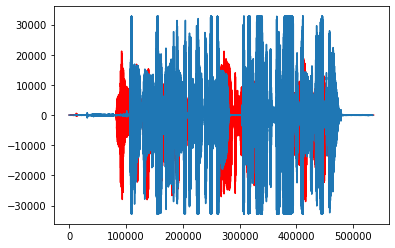

In [109]:
channel_sounds = audio1.split_to_mono()
samples = [s.get_array_of_samples() for s in channel_sounds]
au1 = np.array(samples[0])

channel_sounds = audio2.split_to_mono()
samples = [s.get_array_of_samples() for s in channel_sounds]
au2 = np.array(samples[0])

import matplotlib.pyplot as plt
plt.plot(range(len(au1)), au1, c = 'r')
plt.plot(range(len(au2)), au2)

In [73]:
au1.shape

(535552,)

In [74]:
audio2.frame_rate

48000

In [75]:
au1.max()

21192

array([[ 0,  0,  0, ..., 18, 17, 15]], dtype=int16)

In [ ]:
audio2.get_array_of_samples()

Output hidden; open in https://colab.research.google.com to view.

# Convert to text

## Original sinai model

In [110]:
original_transcriber = Transcriber(model_path=transcribtion_original_model)
original_transcriber.transcribe('demo.wav')

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:349: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['على بابي تردد كم تردد وكم شاء الرحيل وكم ترد']

## Finetuned sinai model

In [111]:
finetuned_transcriber = Transcriber(model_path=transcribition_finetuned_model)
finetuned_transcriber.transcribe('demo.wav')

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:349: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['على بابي تردب كم ترد  وكم شاء الرحيل وكم تردد']

# Text Classification

## Original sinai model

In [112]:
original_text_classifier = TextClassifier(transcriber=original_transcriber)
original_text_classifier.classify('demo.wav')

'الطويل'

## Finetuned Sinai Model

In [113]:
finetuned_text_classifier = TextClassifier(transcriber=finetuned_transcriber)
finetuned_text_classifier.classify('demo.wav')

'الطويل'

# Signal Classification

## Original Sinai Model

In [118]:
original_signal_classifier = SignalClassifier(model_path=signal_classification_original_model_no_shuffled_dataset)
original_signal_classifier.classify('demo.wav')

{'input_values': tensor([[0.0007, 0.0007, 0.0007,  ..., 0.0000, 0.0000, 0.0000]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}


/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1055: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1


tensor([[  3.6926,  -4.9225,  -2.3940,   0.2965,  -0.6762,   7.9303,   5.7043,
           0.6356,  -1.7616, -11.9004,  -6.1424,  -7.5766,  -7.6573,  -1.7002,
          -9.4435,   1.4826]], device='cuda:0')


'الطويل'

## Finetuned Sinai Model

In [115]:
finetuned_signal_classifier = SignalClassifier(model_path=signal_classification_finetuned_model)
finetuned_signal_classifier.classify('demo.wav')

{'input_values': tensor([[0.0007, 0.0007, 0.0007,  ..., 0.0000, 0.0000, 0.0000]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}
tensor([[-0.1131, -3.2852, -1.5189,  2.4704,  8.3688, -0.6799,  2.5492,  0.3223,
         -0.5521, -2.9599,  3.4637, -8.1228, -3.2224,  6.8406, -5.9060, -9.3542]],
       device='cuda:0')


/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1055: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1


'السريع'

In [ ]:
feature_extractor = Wav2Vec2FeatureExtractor(
            feature_size=1,
            sampling_rate=16_000,
            padding_value=0.0,
            do_normalize=True,
            return_attention_mask=True,
        )
processor = CustomWav2Vec2Processor(feature_extractor=feature_extractor)

speech = get_resampled_speech('demo.wav') 
print(speech.max())
features = processor(
    speech[:320000],
    max_length=320000,
    sampling_rate=16000,
    pad_to_multiple_of=320000,
    padding=True,
    return_tensors="pt",
)

# features.input_values = features.input_values /2
print(features.input_values.max())
model = Wav2Vec2ClassificationModel.from_pretrained(signal_classification_original_model).eval()
model.to("cuda")

attention_mask = features.attention_mask.to("cuda")
with torch.no_grad():
    logits = model(
            features.input_values.to("cuda"), attention_mask=attention_mask
        )["logits"]
    print(logits)
    predicted = torch.argmax(
        logits,
        dim=-1,
    )
meter_class = predicted.tolist()[0]
print(meter_class_to_label[meter_class])

0.3351485
tensor(7.2546)


/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:986: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1


tensor([[ 2.0677, -4.1051,  2.9225,  3.9620,  1.4838, -5.5896, -6.3474,  2.9567,
          0.7362,  7.2616,  3.4795,  1.5925,  0.1175,  0.5096,  8.4871, -2.2122]],
       device='cuda:0')
الهزج


In [ ]:
!cp -r /content/drive/MyDrive/KFUPM-Master/ICS606/Dataset/All_poems.zip .

In [ ]:
if os.path.exists('dataset'):
  if len(os.listdir('dataset')) == 0:
    os.system('unzip All_poems.zip -d dataset')
else:
  os.system('unzip All_poems.zip -d dataset')

In [ ]:
!mkdir -p dataset_wav
metadata_test_path = '/content/drive/MyDrive/KFUPM-Master/ICS606/Dataset/testset.csv'
dataset_folder = 'dataset'
dataset_wav_folder = 'dataset_wav'

In [ ]:
metadata = pd.read_csv(metadata_test_path)
metadata

,Unnamed: 0,No.,Utterance name,Script,Bahr,Source,Name when extacted,Original name in document,Further info on Bahr,Name of document,Clean Script,File Exist
0,1872,1883,P-1883.wma,غَيْرَ أَنِّي بِالجَوَى أَعْرِفُها وَهْيَ...,الرمل,NaN,ÛíÑÃäí.wma,غيرأني.wma,NaN,NaN,غير أني بالجوى أعرفها وهي أيضا بالجوى تعرفني,True
1,1290,1296,P-1296.wma,إِلى القُطِع وَما وَلّا ه مِن سَهلٍ وَمِ...,الهزج,NaN,Åáì ÇáÞØÚ.wma,إلى القطع.wma,NaN,NaN,إلى القطع وما ولا ه من سهل ومن وعر,True
2,2567,2601,P-2601.aac,إذا ابتُليتَ فصبرا فالعُسْر يُعقِب يُسرا,المجتث,التذكرة الحمدونية (8/ 68),36.aac,36.aac,NaN,NaN,إذا ابتليت فصبرا فالعسر يعقب يسرا,True
3,2696,2730,P-2730.opus,إِنْ كَانَ فِيْمَا أَقُوْلُ مِنْ كَرَمٍ ف...,المنسرح,الدر الفريد وبيت القصيد (4/ 190),75.opus,75.opus,NaN,NaN,إن كان فيما أقول من كرم فيك مزيد فزادك الله,True
4,1083,1088,P-1088.m4a,يُعْمِلُ البازِلَ المُجِدَّة بالرَّحْـ ـل...,الخفيف,المفضليات تحقيق أحمد شاكر وعبد السلام هارون صـ...,È 10 Þ 3.m4a,ب 10 ق 3.m4a,NaN,NaN,يعمل البازل المجدة بالرح ل تشكى النجاد بع...,True
...,...,...,...,...,...,...,...,...,...,...,...,...
362,559,560,P-560.m4a,الحَمدُ لِلَّهِ ذي البَنِيَّةِ إِذ أَمسَت...,الطويل,ديوان قيس بن الخطيم ص 175,ÇáÊÓÌíá (11).m4a,التسجيل (11).m4a,NaN,NaN,الحمد لله ذي البنية إذ أمست دحي قد أثخنت ...,True
363,239,240,P-240.m4a,نِعَمٌ للَهِ فينا رَبَّها وَصَنيعُ اللَهِ...,الرمل,ديوان سويد اليشكري 30,ÇáÊÓÌíá (85).m4a,التسجيل (85).m4a,NaN,NaN,نعم لله فينا ربها وصنيع الله والله صنع,True
364,2123,2157,P-2157.aac,قَدْ كان له قلبٌ كالطِّفْـ ـلِ يدُ الأحلا...,المتدارك,ديوان الشابي ص128,11.aac,11.aac,NaN,NaN,قد كان له قلب كالطف ل يد الأحلام تهدهده,True
365,1212,1218,P-1218.m4a,وكم قلت سوف يأتي إلى داره الغريب,المضارع,علم العروض والقافية (ص: 108),ÇáÊÓÌíá (28).m4a,التسجيل (28).m4a,NaN,NaN,وكم قلت سوف يأتي إلى داره الغريب,True


In [ ]:
sample_rates = set()
for file_path in tqdm(list(metadata['Utterance name'])):
  complete_path = f'{dataset_folder}/{file_path}'
  complete_wav_path = f'{dataset_wav_folder}/{file_path}'
  # os.system(f'ffmpeg -i {complete_path} {complete_wav_path}')
  audio = AudioSegment.from_file(complete_path)
  sample_rates.add(audio.frame_rate)
  audio.export(f'{dataset_wav_folder}/{file_path}', format='wav')
sample_rates

100%|██████████| 367/367 [01:44<00:00,  3.51it/s]


{44100, 48000}

In [ ]:
dataset = Dataset.from_pandas(metadata)
dataset

Dataset({
    features: ['Unnamed: 0', 'No.', 'Utterance name', 'Script', 'Bahr', 'Source', ' Name when extacted', 'Original name in document', 'Further info on Bahr', 'Name of document', 'Clean Script', 'File Exist'],
    num_rows: 367
})

In [ ]:
original_signal_classifier.classify(f'{dataset_wav_folder}/{dataset[5]["Utterance name"]}')

/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:986: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1


tensor([[ 3.3141e+00, -2.2619e+00,  4.3598e+00,  1.8985e+01, -2.6766e+00,
         -8.5525e-01,  1.8485e+00, -2.4370e+00, -1.2832e-04, -4.4324e+00,
         -8.1015e+00, -5.9583e+00, -1.1563e+01, -4.0340e+00,  1.9429e+00,
         -3.3542e-01]], device='cuda:0')


'الرمل'

In [ ]:
def predict(example):
  example['predicted'] = original_signal_classifier.classify(f'{dataset_wav_folder}/{example["Utterance name"]}')
  return example

In [ ]:
dataset = dataset.map(predict)

In [ ]:
def compute_metrics(preds,labels):
    acc = accuracy_score(labels, preds)
    report = classification_report(labels, preds)
    matrix = confusion_matrix(labels, preds)
    print(matrix)
    print('clasification report',report)
    print('accuracy',acc)

In [ ]:
compute_metrics(preds=[example['predicted'] for example in dataset],labels=[example['Bahr'] for example in dataset])

[[10  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  2  0  0  0  0  0  0  1  0  0  0  1]
 [ 0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1 37  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0 97  3  0  1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  2 17  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0  0  2  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  9  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  5  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 18  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  1  0  1  0  0  0  0  0  0  0  0  0 21  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 39]]
clasification report               precision    recall  f1-score   support

      البسيط       0.83      0.71      0.77        14
      الخفيف       0.88      0.79      0.83        19